### $ \text{Abstract}$

In this notebook I demonstrate a simple object recognition using **OpenCV** library, based on simple image process methods. Different parameters such as ***Gaussian kernel size***, ***binary threshold***, ***Hough transform sensitivity*** - \
will have a direct influence upon the recognition outcome. The general workflow satisfies :

<img src=https://i.imgur.com/Cme04tm.png width=700 />


<a id="1"></a>

### $\text{Processing tools } 🔧$

First the user will enter YouTube URL, from which a desired segment will be cropped. \
Then, it will undergo several procedures (Generally speaking ... 🤫): 


* [**Gaussian filter**](https://en.wikipedia.org/wiki/Gaussian_filter#:~:text=In%20electronics%20and%20signal%20processing,as%20it%20has%20infinite%20support) : $$
G(x, y, \sigma) = \frac{1}{2 \pi \sigma^2} e^{- \frac{x^2+y^2}{2 \sigma^2}} \quad \Rightarrow \quad \nabla^2 (I^t * G(x, y)) = I^t * \nabla^2 G(x, y) $$
* [**Hough transform**](https://en.wikipedia.org/wiki/Hough_transform) : $$ r = x \cdot \cos \theta + y \cdot \sin \theta \quad \Leftrightarrow \quad y = - \frac{\cos \theta}{\sin \theta} \cdot x + \frac{r}{\sin \theta} $$
* [**Image dilation**](https://en.wikipedia.org/wiki/Dilation_(morphology)) : $$
I_{(x,y)} \oplus B = \bigcup_{b\in B} A_b \quad \quad B:=\text{structuring element}
$$
* [**Image differencing**](https://en.wikipedia.org/wiki/Image_differencing) : $$
I_{(x, y)}^{t+1} - I_{(x, y)}^{t} \quad \forall \quad t := \text{frame}
$$

After extracting the object's visual features, the shape is delineate as such :

<img src=https://i.imgur.com/22eqlrF.png width=300 />

* [**Bounding box**](https://machinelearningmastery.com/object-recognition-with-deep-learning/) : 
$$ \  \ (x_1, y_1) = \big( \max (iX) \, , \, \max (iY) \big) \\  \ (x_2, y_2) = \big( \min (iX) \, , \ \min (iY) \big)  $$

> Based on my "*Tutorial : YouTube to MP4* 🎥"  [[ **link** ](https://www.kaggle.com/daniboy370/tutorial-youtube-to-mp4)]

In [1]:
# Install required libraries
!pip3 install --upgrade pip
!pip install moviepy
!pip install pytube3

# Import libraries
import os
import cv2
import moviepy
import numpy as np 
from pytube import YouTube
from datetime import timedelta
from IPython.display import YouTubeVideo
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

URL_YouTube = 'https://www.youtube.com/watch?v=d-souLImH-I'

     |████████████████████████████████| 1.5MB 4.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


* Based on my "*Tutorial : YouTube to MP4* 🎥"  [[ **link** ](https://www.kaggle.com/daniboy370/tutorial-youtube-to-mp4)]

* Let us pick a video from YouTube and extract a specific segment of my interest :


<a id="2"></a> 
<img src=https://i.imgur.com/JmOvb15.png width=450/>

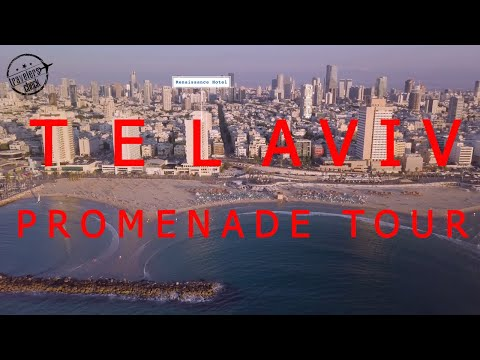

In [2]:
def YouTube_time_window(url, **kwargs):
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

DIR_new = 'Download/'
# os.getcwd()       # Check current working directory  

if not os.path.exists('/content/' + DIR_new):
    os.mkdir(DIR_new)
    os.chdir('/content/'+DIR_new)

# enter time window [hr;mn;sec]
time_start = int(timedelta(hours=0, minutes=0, seconds=57).total_seconds())

# enter Duration [sec]
time_duration = 25

# Launch
time_end = time_start + time_duration
width, height = 550, 350
YouTube_time_window(URL_YouTube, start=time_start, width=width, height=height)


### $\text{Trim video : } ✂️ $  🎞️

Normally there is **no need** in the entire footage, but only in a certain **clipped** footage :

In [3]:
# Download and rename files 
Video_file_raw = YouTube(URL_YouTube).streams.first().download()
DIR_vid = '/content/Download/'
Video_file = DIR_vid + 'Vid_in.mp4'
os.rename(Video_file_raw, Video_file)

# Extract desired segment 
Video_out_name = 'Vid_out.mp4'
ffmpeg_extract_subclip(Video_file, time_start, time_end, targetname=Video_out_name)

# WARNING : for some reason it's not working on colab (!)
# Video(Video_out_name, width=width, height=height)



[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i /content/Download/Vid_in.mp4 -ss 57.00 -t 25.00 -vcodec copy -acodec copy Vid_out.mp4
... command successful.


<a id="3"></a>
### $\text{IP Algorithms : } $ 📈

This section contains the algorithmic core (manually written) that implements the above formulation :

In [4]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_the_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_image, (x1,y1), (x2,y2), (255, 0, 0), thickness=5)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img

def process(image):
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [(0, height), (width/2, height/2), (width, height)]
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    canny_image = cv2.Canny(gray_image, 100, 120)
    cropped_image = region_of_interest(canny_image,
                                       np.array([region_of_interest_vertices], np.int32))
    lines = cv2.HoughLinesP(cropped_image, rho=2, theta=np.pi/180, threshold=50,
                           lines=np.array([]), minLineLength=40, maxLineGap=100)
    image_with_lines = draw_the_lines(image, lines)
    return image_with_lines

In [5]:
cap = cv2.VideoCapture(DIR_vid + 'Vid_out.mp4')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
vid_out = cv2.VideoWriter(DIR_vid + 'Vid_Mask.mp4', fourcc, 20, (int(cap.get(3)), int(cap.get(4))))

# ----------------- Initialization ----------------- #
_, img_org = cap.read()
frame1 = img_org; frame2 = frame1
frame_i, frame_tot = 0, 480

while cap.isOpened() & (frame_i < frame_tot):
    if (frame_i%25 == 0):
        print('frame : %d / %d'% (frame_i, frame_tot) )
    frame_i = frame_i + 1 # frame_idx
    # ------- Hough Transform for alignment -------- #
    frame2 = process(frame2)
    # cv2_imshow(frame2)

    # -------------- Object Detection -------------- #
    diff = cv2.absdiff(frame1, frame2)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (29, 29), 0)
    _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, None, iterations=3)
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)

        if cv2.contourArea(contour) < 500:
            continue
        cv2.rectangle(frame1, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.drawContours(frame1, contours, -1, (0, 0, 255), 1)
    vid_out.write(frame1)
    # cv2_imshow(frame1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # ------------- Towards next step ------------- #
    frame1 = frame2
    _, frame2 = cap.read()
    # frame2 = cv.resize(frame2, low_res) # uncomment to resize resolution

cap.release()
vid_out.release()
cv2.destroyAllWindows()

frame : 0 / 480
frame : 25 / 480
frame : 50 / 480
frame : 75 / 480
frame : 100 / 480
frame : 125 / 480
frame : 150 / 480
frame : 175 / 480
frame : 200 / 480
frame : 225 / 480
frame : 250 / 480
frame : 275 / 480
frame : 300 / 480
frame : 325 / 480
frame : 350 / 480
frame : 375 / 480
frame : 400 / 480
frame : 425 / 480
frame : 450 / 480
frame : 475 / 480


## $\text{Voilà : }$ 🎉

<img src=https://github.com/Daniboy370/Computer-Vision/raw/master/OpenCV_Demo/Upload/Github_GIF.gif width=800/>

<a id="4"></a>
### $\text{Download : } 📥$

<img src=https://i.imgur.com/4xx3Gti.png width="325" />